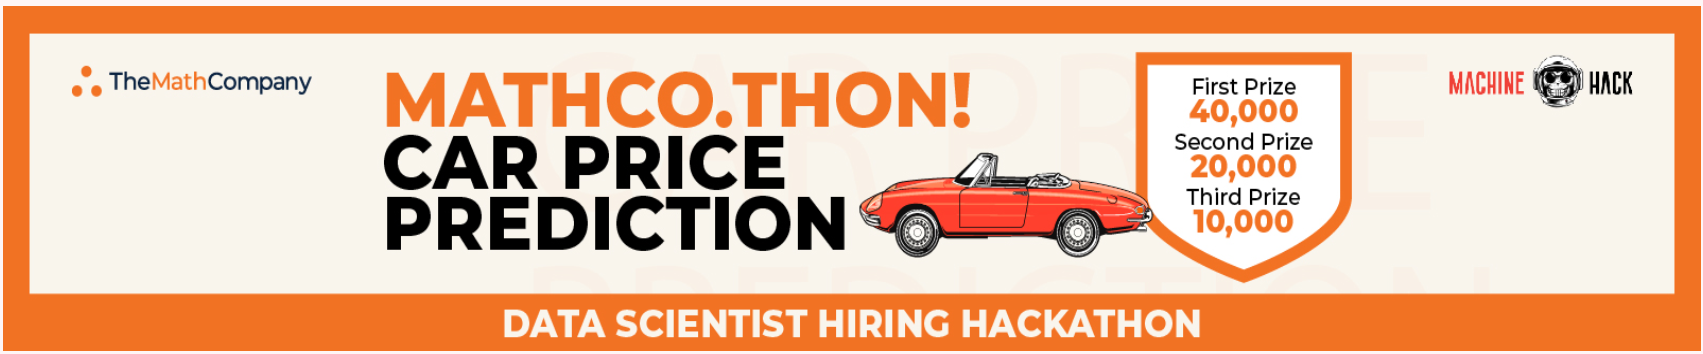

### Car Price Prediction

With the rise in the variety of cars with differentiated capabilities and features such as model, production year, category, brand, fuel type, engine volume, mileage, cylinders, colour, airbags and many more, came forward a car price prediction challenge.

#### Import Necessary Libraries

In [39]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import plotly.express as px

import numpy as np

from category_encoders import CountEncoder

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

#### Loading the Dataset

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df['origin'] = 'train'
test_df['origin'] = 'test'
df = pd.concat([train_df, test_df])

#### Basic EDA

In [5]:
def basic_eda(df):
    print('SHAPE')
    print('Train:', train_df.shape, '\nTest:', test_df.shape)
    print('.' * 100)
    print('\nINFO')
    print(df.info())
    print('.' * 100)
    print('\nMISSING VALUES')
    print('Total Missing:', df.isna().sum().sum())
    print(df.isna().sum().sort_values(ascending = False))
    print('.' * 100)
    print('\nDUPLICATES')
    print(df.duplicated().sum())
    print('.' * 100)  
    print('\nDESCRIBE')
    print(df.describe())


basic_eda(df)

SHAPE
Train: (19237, 19) 
Test: (8245, 19)
....................................................................................................

INFO
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27482 entries, 0 to 8244
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                27482 non-null  int64  
 1   Price             19237 non-null  float64
 2   Levy              27482 non-null  object 
 3   Manufacturer      27482 non-null  object 
 4   Model             27482 non-null  object 
 5   Prod. year        27482 non-null  int64  
 6   Category          27482 non-null  object 
 7   Leather interior  27482 non-null  object 
 8   Fuel type         27482 non-null  object 
 9   Engine volume     27482 non-null  object 
 10  Mileage           27482 non-null  object 
 11  Cylinders         27482 non-null  float64
 12  Gear box type     27482 non-null  object 
 13  Drive wheels      27482 non-null

In [6]:
print('Unique values in the dataset:\n')

for i in df.columns:
    print('_' * 50)
    print(i + ':', df[i].nunique(), df[i].dtype)
    print(df[i].value_counts())

Unique values in the dataset:

__________________________________________________
ID: 26886 int64
45815363    10
45786465    10
45815365    10
45815366     9
45720276     9
            ..
45651960     1
45803510     1
45809653     1
45731827     1
25368573     1
Name: ID, Length: 26886, dtype: int64
__________________________________________________
Price: 2315 float64
15681.0    280
470.0      274
14113.0    244
392.0      242
314.0      235
          ... 
12950.0      1
56431.0      1
34111.0      1
18948.0      1
13322.0      1
Name: Price, Length: 2315, dtype: int64
__________________________________________________
Levy: 635 object
-       8273
765      708
891      665
640      582
639      575
        ... 
5908       1
1901       1
557        1
1103       1
955        1
Name: Levy, Length: 635, dtype: int64
__________________________________________________
Manufacturer: 68 object
HYUNDAI          5358
TOYOTA           5177
MERCEDES-BENZ    2983
FORD             1592
CHEVROLET  

#### Data Preparation, Feature Engineering & Feature Transformation

In [7]:
df.columns = df.columns.str.replace(' ', '_')

In [8]:
df['Levy'].replace('-', 0, inplace = True)
df['Levy'] = df['Levy'].astype('int64')
df['Levy'] = np.where(df['Levy'] > 6000, 6000, df['Levy'])
df['Levy'] = np.log1p(df['Levy'])

In [9]:
df['Fuel_type'].replace('Hydrogen', df['Fuel_type'].mode()[0], inplace = True)

In [10]:
df.drop(df[df['Manufacturer'] == 'LAMBORGHINI'].index, inplace = True)

In [11]:
df[['Engine_Vol', 'Turbo']] = df['Engine_volume'].str.split(' ', expand = True)
df['Engine_Vol'] = df['Engine_Vol'].astype('float')
df['Engine_Vol'] = np.where(df['Engine_Vol'] > 10, df['Engine_Vol'].mean(), df['Engine_Vol']) 
df['Turbo'] = df['Turbo'].replace([None, 'Turbo'], [0, 1])
df.drop(['Engine_volume'], axis = 1, inplace = True)

In [12]:
df['Airbags'] = np.where(df['Airbags'] > 12, 13, df['Airbags']) 

In [13]:
df['Doors'].replace(['04-May', '02-Mar', '>5'], [4, 2, 6], inplace = True) 

In [14]:
df['Mileage'] = df['Mileage'].str.replace(' km', '') 
df['Mileage'] = df['Mileage'].astype('int64')
df['Mileage'] = np.log1p(df['Mileage'])

In [15]:
df['Price'] = np.where((df['Price'] > 400000) & (df['Model'] == 'Combo'), 
                       df[df['Model'] == 'Combo']['Price'].median(), 
                       df['Price'])
df['Price'] = np.where((df['Price'] > 400000) & (df['Manufacturer'] == 'MERCEDES-BENZ'), 
                       df[df['Manufacturer'] == 'MERCEDES-BENZ']['Price'].median(), 
                       df['Price'])

df['Price'] = np.log1p(df['Price'])

In [16]:
df['Year_group'] = pd.cut(df['Prod._year'], bins = [1900, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], 
                          labels = [0, 1, 2, 3, 4, 5, 6, 7, 8])
df['Year_group'] = df['Year_group'].astype('int64')

In [17]:
df['Cylinders'] = np.where((df['Cylinders'] > 16) & (df['Model'] == 'Captiva'), 
                           df[df['Model'] == 'Captiva']['Cylinders'].mode()[0], 
                           df['Cylinders'])

In [18]:
df['Model'] = df['Model'].str.lower()
df['Model'] = df['Model'].str.replace(',', '.')
df['Model'] = df['Model'].str.strip()

# cleaned some model names here and then split by words
model = ['09-mar', '100', '100 nx', '1000', '1111', '114', '116', '116 i', '118', '118 2.0', '118 m-sport lci', '120', '124 spider', '128', '128 3.0', '128 m tech', '130', '1300', '135', '147', '1500', '1500.1600 schtufenheck', '156', '159', '166', '19', '190', '20', '200', '206', '206 cc', '207', '208', '21', '21 3.0', '2101 01', '2103', '2103 03', '2105', '2106', '2106 06', '2107', '2107 07', '2109', '21099', '2111', '2121 (niva)', '2121 (niva) 1700', '2121 (niva) 21213', '2140', '216', '220', '220 w153', '225', '230', '230 w153', '24', '24 10', '240', '250', '270', '2705', '280', '290', '3 tf 135', '3.18e+38', '3.18e+48', '3.20e+38', '3.25e+48', '300', '300 limited', '300 s', '3000 gt', '3008', '3008 2.0', '307', '307 sw', '311', '3110', '31105', '31514', '31514 uaz', '316', '316 1995', '316 i', '318', '318 1.8 m43', '318 2.5', '318 318', '318 is', '318 m', '318 რესტაილინგი', '318 სასწრაფოდ', '320', '320 1.9is', '320 2.0', '320 2.2', '320 320', '320 diesel', '320 gran turismo', '320 i', '320 i xdrive', '320 m', '32214', '322173', '323', '323 f', '325', '325 2v', '325 ci', '325 i', '325 xi', '328', '328 2.8', '328 330', '328 dizel', '328 drift car', '328 f30', '328 i', '328 sulev', '328 xdrive', '330', '330 330', '335', '335 335i', '335 d', '335 m paket', '335 ტურბო', '340', '370z', '3796', '400', '400x', '401', '406', '407', '416', '420', '423 kombi', '428', '428 i', '428 sport line', '435', '435 cupe', '456', '4runner', '4runner limited', '5.30e+62', '50', '500', '500 46 ml', '500 abarth', '500 abarth ტურბო', '500 gucci', '500 lounge', '500 s', '500 sport', '500 sport panorama', '500 turbo', '500 მარჯვენა საჭე', '500c', '500c lounge', '500l', '500l long', '500x', '500x eyzi', '500x lounge', '508', '520', '520 2.2', '520 d xdrive luxury', '520 egzekutive', '520 i', '520 vanos', '523', '525', '525 ///m', '525 2.5turbo', '525 525', '525 i', '525 tdi', '525 vanos', '528', '528 2.0 ტურბო', '528 3.0', '528 f10', '528 i', '528 m pack', '530', '530 525i', '530 530', '530 g30', '530 gt', '530 i', '530 m', '530 დიზელი', '535', '535 535', '535 comfort-sport', '535 diesel', '535 i', '535 i xdrive', '535 m', '535 m paket', '535 m5', '535 twinturbo', '535 xi', '540', '540 i', '545', '550', '550 f10', '550 gt', '550 m packet', '607', '616', '626', '630', '635', '640', '640 gran-coupe', '640 m', '645', '645 ci', '650', '650 450 hp', '7.30e+34', '730', '730 3.0', '735', '740', '740 i', '745', '745 i', '750', '750 4.8', '750 l japan', '807', '911', '911 meqanika', '940', '960', '969', '969 968m', '969 luaz', '969 m', 'a 140', 'a 140 140', 'a 160', 'a 170', 'a 170 avangard', 'a 170 cdi', 'a 190', 'a 200', 'a 220', 'a3', 'a3 4x4', 'a3 premium', 'a4', 'a4 2.0 tfsi', 'a4 b5', 'a4 b6', 'a4 b7', 'a4 premium', 'a4 premium plius', 'a4 s line', 'a4 s4', 'a4 sline', 'a5', 'a5 premium plus', 'a5 s line', 'a5 sportback', 'a6', 'a6 c7', 'a6 evropuli', 'a6 premium', 'a6 premium plus', 'a6 quattro', 'a6 s-line', 'a6 suprecharge', 'a6 universal', 'a6 с6', 'a7', 'a7 prestige', 'a7 supercharged', 'a8', 'a8 l', 'acadia', 'accent', 'accent gs', 'accent se', 'accord', 'accord cl9 type s', 'actyon', 'aerio', 'aerio sx', 'agila', 'airtrek', 'airtrek restyling', 'airtrek turbo', 'allante', 'allroad', 'allroad a6', 'allroad allroad', 'almera', 'almera dci', 'alphard', 'altezza', 'altima', 'alto lapin', 'amg gt s', 'antara', 'aqua', 'aqua 2013', 'aqua 2014', 'aqua aqua', 'aqua g', 'aqua g klas', 'aqua g paketi', 'aqua g soft leather sele', 'aqua hibrid', 'aqua l paketi', 'aqua s', 'aqua sport', 'aqua სასწრაფოდ', 'aqua ჰიბრიდი', 'armada', 'astra', 'astra 1.6', 'astra 1600', 'astra a.h', 'astra astra', 'astra bertone', 'astra bertoni', 'astra cng', 'astra f', 'astra g', 'astra ge', 'astra gi', 'astra gtc 1.9 turbo dies', 'astra h', 'astra j', 'astra prastoi 1.6', 'astra suzuki mr wagon', 'astra td', 'astra ინსიგნია', 'astra სასწრაფოდ', 'atenza', 'ats', 'auris', 'avalanche', 'avalon', 'avalon limited', 'avella', 'avenger', 'avensis', 'aveo', 'axela', 'azera', 'b 170', 'b 170 b class', 'b 170 edition one', 'b 180', 'b 200', 'b 200 turbo', 'b 220', 'b-max', 'b9 tribeca', 'bb', 'belta', 'berlingo', 'blade', 'blazer', 'bluebird', 'bora', 'brava', 'brevis', 'brz', 'c 180', 'c 180 2.0', 'c 180 c - 1.8', 'c 180 europe', 'c 180 komp', 'c 180 კომპრესორი', 'c 200', 'c 200 2.0', 'c 200 7g-tronic', 'c 200 kompressor', 'c 220', 'c 220 avag', 'c 220 cdi', 'c 220 d premium', 'c 230', 'c 230 2.0 kompresor', 'c 230 2.5', 'c 230 kompresor', 'c 240', 'c 240 w 203', 'c 240 w203', 'c 250', 'c 250 1.8', 'c 250 1.8 turbo', 'c 250 1.8 turbo amg', 'c 250 1.8 ტურბო', 'c 250 a.m.g', 'c 250 amg', 'c 250 amg-paket-1.8', 'c 250 luxury', 'c 270', 'c 270 cdi', 'c 280', 'c 300', 'c 300 300', 'c 300 4matic', 'c 300 6.3 amg package', 'c 300 amg', 'c 300 sport', 'c 32 amg', 'c 320', 'c 320 amg', 'c 320 cdi', 'c 350', 'c 36 amg', 'c 400', 'c 43 amg', 'c 63 amg', 'c-crosser cruze', 'c-max', 'c-max c-max', 'c-max hybrid', 'c-max premium', 'c-max se', 'c-max sel', 'c-max დატენვადი ჰიბრიდი', 'c1', 'c1 c', 'c30', 'c30 2010', 'c4', 'c5', 'c70', 'c8', 'caddy', 'caddy cadi', 'cadenza', 'caldina', 'caliber', 'caliber 2011', 'caliber journey', 'caliber sxt', 'california', 'camaro', 'camaro ls', 'camaro rs', 'cami', 'camry', 'camry 87000', 'camry hybrid', 'camry le', 'camry limited', 'camry s', 'camry se', 'camry se hibryd', 'camry se sport', 'camry sel', 'camry sport', 'camry sport paket', 'camry sport se', 'camry sporti', 'camry v70', 'camry xle', 'camry xle hybrid', 'camry xlei', 'camry xse', 'camry xv50', 'camry ჰიბრიდი', 'captiva', 'captur', 'captur qm3 samsung', 'caravan', 'caravan tradesman', 'carens', 'carisma', 'carnival', 'carnival grand', 'catera', 'cavalier', 'cayenne', 'cayenne s', 'cayman', 'cc', 'cc 2.0 t', 'cc r line', 'cc sport', 'ceed', 'cefiro', 'celica', 'century', 'cerato', 'cerato k3', 'cervo', 'challenger', 'charger rt', 'chariot', 'chariot rvr', 'cherokee', 'chr', 'chr limited', 'cinquecento', 'citan', 'civic', 'civic 14', 'civic coupe', 'civic crz', 'civic ex', 'civic exl', 'civic ferio', 'civic hybrid', 'civic hybrid l', 'cl 500', 'cl 55 amg kompressor', 'cl 550', 'cl 600', 'cl550 amg', 'cla 200', 'cla 250', 'cla 250 amg', 'cla 45 amg', 'clarity', 'clarus', 'clio', 'clk 200', 'clk 200 200', 'clk 200 208', 'clk 200 kompresor', 'clk 200 kompressor', 'clk 230', 'clk 230 .', 'clk 240', 'clk 270', 'clk 280', 'clk 320', 'clk 320 amg', 'clk 320 avangarde', 'clk 350', 'clk 430', 'clk 500', 'clk 55 amg', 'cls 320', 'cls 350', 'cls 350 amg', 'cls 350 japan', 'cls 450 cls 400', 'cls 500', 'cls 500 amg', 'cls 55 amg', 'cls 55 amg kompressor', 'cls 550', 'cls 550 550', 'cls 63 amg', 'clubman', 'colorado', 'colt', 'colt 1.3 prastoi', 'colt lancer', 'coltplus', 'coltplus plus', 'combo', 'combo 1700', 'combo 2001', 'combo tdi', 'combo turbo', 'compass', 'continental', 'continental gt', 'cooper', 'cooper clubman', 'cooper f-56', 'cooper r50', 'cooper s', 'cooper s cabrio', 'cooper s cabrio r56', 'cooper სასწრაფოდ', 'corolla', 'corolla 04', 'corolla 140', 'corolla eco', 'corolla im', 'corolla le', 'corolla s', 'corolla se', 'corolla spacio', 'corolla verso', 'corolla yaris ia', 'corsa', 'corsa b', 'corsa c', 'corsa corsa', 'corvette', 'cougar', 'countryman', 'countryman one', 'countryman s', 'countryman s all4', 'countryman s turbo', 'countryman sport', 'courier', 'cr-v', 'cr-v cr-v', 'cr-v lx', 'cr-v მექანიკა', 'cr-z', 'cr-z mt', 'cr-z ჰიბრიდი', 'crafter', 'crafter 2.5 tdi', 'crafter 2.5tdi', 'crossfire', 'crossland x', 'crossroad', 'crosstour', 'crosstrek', 'crosstrek xv', 'cruze', 'cruze cruze', 'cruze diesel', 'cruze l t', 'cruze limited lt2', 'cruze ls', 'cruze lt', 'cruze lt rs', 'cruze ltz', 'cruze premier', 'cruze rs', 'cruze s', 'cruze sonic', 'cruze strocna', 'crx', 'ct 200h', 'ct 200h 1.8', 'ct 200h f sport', 'ct 200h f-sport', 'cts', 'cts bls', 'cube', 'cuore', 'cx-3', 'cx-3 grand tauring', 'cx-5', 'cx-5 sport', 'cx-5 touring', 'cx-7', 'cx-7 mzr', 'cx-9', 'daimler', 'dakota v8 magnum', 'dart', 'dart gt 2.4', 'dart limited', 'db7 vantage volante', 'defender', 'defender 90 cabrio', 'delica', 'delica 5', 'demio', 'demio 12', 'demio evropuli', 'demio mazda2', 'demio sport', 'discovery', 'discovery 3', 'discovery iv', 'discovery lr3', 'doblo', 'doblo max', 'ds 4', 'dts', 'durango', 'duster', 'e 200', 'e 200 2000', 'e 200 4', 'e 200 cdi', 'e 200 cgi', 'e 200 w210', 'e 200 w212', 'e 220', 'e 220 211', 'e 220 cdi', 'e 220 elegance', 'e 220 w210...cdi', 'e 230', 'e 230 124', 'e 240', 'e 240 e 240', 'e 250', 'e 260', 'e 270', 'e 270 4', 'e 270 avangardi', 'e 270 cdi', 'e 280', 'e 280 3.0', 'e 280 cdi', 'e 290', 'e 300', 'e 300 avantgarde-ltd', 'e 320', 'e 320 4matic', 'e 320 4×4', 'e 320 bluetec', 'e 320 cdi', 'e 350', 'e 350 212', 'e 350 4 matic', 'e 350 4 matic amg packag', 'e 350 4matic', 'e 350 amg', 'e 350 amg pack', 'e 350 bluetec', 'e 350 w211', 'e 350 ამგ', 'e 36 amg', 'e 400', 'e 420', 'e 430', 'e 430 avantgarde', 'e 50', 'e 500', 'e 500 amg', 'e 500 avg', 'e 55', 'e 550', 'e-pace', 'e-pace p200', 'eclipse', 'eclipse es', 'eclipse se', 'ecosport', 'ecosport se', 'edge', 'edix', 'edix fr-v', 'elantra', 'elantra 2014', 'elantra 2016', 'elantra avante', 'elantra gls', 'elantra gls / limited', 'elantra gs', 'elantra gt', 'elantra i30', 'elantra limited', 'elantra limitedi', 'elantra se', 'elantra sport limited', 'elantra ლიმიტედი', 'element', 'elgrand', 'elgrand alwe50', 'elysion', 'elysion 3.0', 'enclave', 'encore', 'envoy', 'eos', 'equinox', 'equinox lt', 'es 300', 'es 300 hibrid', 'es 300 hybrid', 'es 350', 'escalade', 'escape', 'escape 3', 'escape 3.0', 'escape escape', 'escape hybrid', 'escape limited', 'escape se', 'escape titanium', 'escape xlt', 'escape მერკური მერინერი', 'escape სასწრაფოდ', 'escort', 'escudo', 'estima', 'estima hibrid', 'eunos 500', 'every landy nissan seren', 'ex35', 'ex37', 'expedition', 'explorer', 'explorer edibauer', 'explorer turbo japan', 'explorer xlt', 'f-pace', 'f-type', 'f-type r', 'f150', 'f350', 'f50', 'fabia', 'familia wagon', 'feroza', 'fiesta', 'fiesta 1.6', 'fiesta se', 'fiesta titanium', 'fit', 'fit "s"- paketi.', 'fit aria', 'fit ex', 'fit fit', 'fit gp-5', 'fit gp-6', 'fit hbrid', 'fit hibrid', 'fit hybrid', 'fit hybryd', 'fit l', 'fit lx', 'fit modulo', 'fit navi premium', 'fit premium paketi', 'fit premiumi', 'fit premiym', 'fit rs', 'fit rs modeli', 'fit rs mugen', 'fit s', 'fit sport', 'fit sport ( rs )', 'fj cruiser', 'focus', 'focus es', 'focus flexfuel', 'focus fokusi', 'focus plug-in titanium', 'focus se', 'focus sel', 'focus st', 'focus titanium', 'forester', 'forester 2.0xt (turbo)', 'forester 2.5', 'forester 4x4', 'forester cross sport', 'forester crosssport', 'forester l.l.bean', 'forester legacy', 'forester limited', 'forester premium', 'forester sg5 xt', 'forester sh', 'forester stb', 'forester touring', 'forester xt', 'forte', 'fortuner', 'fox', 'fr-v', 'fred', 'fred hibridi', 'freelander', 'freelander 1.7 turbo diz', 'freelander v6', 'frontera', 'frontera a b', 'frontier', 'fuga', 'fuga 350gt', 'fun cargo', 'fusion', 'fusion 1.6', 'fusion 2015', 'fusion bybrid', 'fusion hibrid', 'fusion hybrid', 'fusion hybrid se', 'fusion phev', 'fusion plug in', 'fusion se', 'fusion se ekoboost', 'fusion se hybrid', 'fusion titanium', 'fusion titaniumi', 'fusion ჰიბრიდი', 'fx35', 'fx45', 'g 230 2.2cdi', 'g 300', 'g 320', 'g 350', 'g 55 amg', 'g 550', 'g 63 amg', 'g 65 amg 63amg', 'g 65 amg g63 amg', 'g20', 'g25', 'g35', 'g35 x', 'g37', 'g6', 'galant', 'galant gts', 'galaxy', 'galloper', 'genesis', 'gentra', 'getz', 'getz gls', 'ghibli', 'giulietta', 'gl 320', 'gl 320 bluetec', 'gl 350', 'gl 350 7 ადგილიანი', 'gl 350 bluetec', 'gl 350 blutec', 'gl 350 დიზელი', 'gl 450', 'gl 450 3.0', 'gl 450 4matic', 'gl 500', 'gl 550', 'gl 63 amg', 'gla 200', 'gla 250', 'gla 250 4matic', 'glc 250', 'glc 300', 'glc 300 glc coupe', 'gle 350', 'gle 350 a m g', 'gle 350 amg', 'gle 400', 'gle 400 a m g', 'gle 400 amg', 'gle 400 coupe. amg kit', 'gle 43 amg', 'gle 450', 'gle 63 amg', 'glk 250', 'glk 300', 'glk 320', 'glk 350', 'gloria', 'gls 450', 'gls 63 amg', 'golf', 'golf 1.8', 'golf 2', 'golf 3', 'golf 4', 'golf 5', 'golf 6', 'golf 7', 'golf golf 5', 'golf gt', 'golf gti', 'golf mk3', 'golf plus', 'golf r', 'golf tdi', 'gonow', 'grand cherokee', 'grand cherokee laredo', 'grand cherokee overland', 'grand cherokee saiubileo', 'grand cherokee special e', 'grand cherokee srt.8', 'grand hiace', 'grand vitara', 'grand vitara nomade', 'grandeur', 'grandis', 'gs 300', 'gs 350', 'gs 450', 'gs 450 hybrid', 'gti', 'gti jetta', 'gx 460', 'gx 470', 'gx 470 470', 'gx 470 gx470', 'gx 470 suv 4d 4.7l v8 s', 'h1', 'h1 grand starex', 'h1 grandstarex', 'h1 starixs', 'h2', 'h3', 'h6', 'harrier', 'hhr', 'hiace', 'zafira b', 'zafira 12', 'zafira 1.9 tdi', 'zafira', 'z4 3.0 si', 'z4', 'yukon', 'yrv', 'yaris se', 'yaris rs', 'yaris ia', 'yaris', 'xv limited', 'xv hybrid', 'xv crosstrek', 'xv', 'xsara picasso', 'xl7 limited', 'xl7', 'xk', 'xjl', 'xj6', 'xj', 'xf', 'xe', 'xd', 'xc90 3.2 awd', 'xc90 2.5turbo', 'xc90', 'xc60', 'x6 m', 'x6 limited', 'x6 germany', 'x6 40d', 'x6', 'x5 xdrive 35d', 'x5 xdrive', 'x5 xdr40e', 'x5 x5', 'x5 x-drive', 'x5 sport', 'x5 restilling', 'x5 rest', 'x5 m packet', 'x5 m', 'x5 japan', 'x5 f15', 'x5 e70', 'x5 e53', 'x5 diesel', 'x5 4x4', 'x5 4/4turbo', 'x5 4.8is', 'x5 4.4i', 'x5 35d', 'x5 350d', 'x5 30sd', 'x5 3.5', 'x5 3.0i', 'x5 3.0', 'x5', 'x4', 'x3 sdrive', 'x3 3.5i', 'x3', 'x1 xdrive335i', 'x1 xdraiv', 'x1 x-drive', 'x1 4x4', 'x1 28xdrive', 'x1', 'x-type', 'x-trail x-trail', 'x-trail t30', 'x-trail nissan x trail r', 'x-trail nismo', 'x-trail lpg', 'x-trail gt', 'x-trail axis', 'x-trail 4x4', 'x-trail', 'x-terra', 'x 250 ევროპული', 'x 250', 'wrangler sport', 'wrangler arb', 'wrangler', 'wizard', 'wish', 'wingroad', 'will vs', 'will chypa', 'wagon r+', 'vue', 'voyager', 'voxy 2003', 'voxy', 'voltz', 'volt restailingi', 'volt premier', 'volt full packet', 'volt', 'vitz rs', 'vitz i.ll', 'vitz funkargo', 'vitz', 'vito long115', 'vito extralong', 'vito extra long', 'vito exstralong', 'vito 2.2', 'vito 116', 'vito 115 cdi', 'vito 115', 'vito 113', 'vito 111 cdi', 'vito 111', 'vito 110d', 'vito', 'vitara gl+', 'vitara', 'virage', 'viano cd 3.0', 'viano ambiente', 'viano', 'vesta', 'verso', 'versa se', 'versa s', 'versa note', 'versa', 'verisa 2007', 'verisa', 'veracruz', 'venza', 'vento', 'veloster turbo', 'veloster remix', 'veloster r-spec', 'veloster', 'vehicross', 'vectra ბ', 'vectra а', 'vectra h', 'vectra c', 'vectra b', 'vectra 1.6', 'vectra', 'vanette', 'vaneo', 'vamos', 'v50', 'v 230', 'v 220', 'up', 'twingo', 'tundra', 'tucson turbo', 'tucson se', 'tucson limited', 'tucson ix 20', 'tucson', 'tt', 'tsx', 'trooper', 'tribute სასწრაფოდ', 'tribute', 'trezia', 'trax', 'traverse lt', 'traverse', 'transporter', 'transit სასწრაფოდ', 'transit პერეგაროტკა', 'transit trend', 'transit transit', 'transit tourneo', 'transit t330', 'transit s', 'transit ford', 'transit fff', 'transit dublkabina', 'transit custom', 'transit connect ბენზინი', 'transit connect prastoi', 'transit connect', 'transit cl', 'transit 88 kw', 'transit 74 turbo', 'transit 350t', 'transit 2.4', 'transit 150', 'transit 135', 'transit 100ld', 'transit', 'trailblazer', 'town car', 'town and country', 'tourneo connect', 'touran', 'touareg', 'tlx', 'tl saber', 'tl', 'titan', 'tiida tida', 'tiida latio', 'tiida axis', 'tiida 2008', 'tiida 15 m', 'tiida', 'tiguan se', 'tiguan s', 'tiguan', 'tigra', 'tico', 'terrano', 'terrain', 'terios', 'teana', 'tc', 'taurus x', 'taurus interceptor', 'taurus', 'taunus', 'tahoe', 'tacoma trd off road', 'tacoma', 't5', 't3 0000', 't3', 'sx4', 'swift sport', 'swift', 'superb', 'suburban', 'stream rsz', 'stream', 'stilo', 'step wagon spada z', 'step wagon rg2 spada', 'step wagon pada', 'step wagon', 'stella', 'srx', 'sprinter ქირავდება', 'sprinter სატვირთო', 'sprinter vip class', 'sprinter van', 'sprinter maxi-ს max', 'sprinter max', 'sprinter euro4', 'sprinter 516', 'sprinter 411', 'sprinter 316 cdi', 'sprinter 316', 'sprinter 315cdi-xl', 'sprinter 315cdi', 'sprinter 314', 'sprinter 313cdi', 'sprinter 313', 'sprinter 311', 'sprinter 308 cdi', 'sprinter 2.7', 'sprinter', 'sportage v6', 'sportage sx', 'sportage prestige', 'sportage ex', 'sportage 4th gen', 'sportage', 'spark', 'space runner', 'soul sxl', 'soul', 'sorento sx', 'sorento ex', 'sorento 2.4', 'sorento', 'sonic lt', 'sonic', 'sonata სასწრაფოდ', 'sonata sport limited', 'sonata sport', 'sonata se limited', 'sonata se', 'sonata s', 'sonata lpg', 'sonata limited', 'sonata hybrid', 'sonata hv', 'sonata hibrid', 'sonata eco', 'sonata brilianti', 'sonata blue edition', 'sonata 2015', 'sonata 2.4l', 'sonata 2.0t', 'sonata', 'smart fortwo', 'smart for two', 'smart', 'slk 350 300', 'slk 32 amg', 'slk 230', 'slk 200', 'sl 55 amg', 'skyline gt250', 'skyline 4wd', 'skyline 250gt', 'skyline', 'sj 413 samurai', 'sirion', 'sintra', 'silvia', 'silverado', 'sierra dizel', 'sierra', 'sienta le', 'sienta', 'sienna', 'shuttle', 'sharan', 'serena serea', 'serena hibrid', 'serena', 'sequoia', 'sentra', 'seicento fiat 600', 'sedona', 'sebring', 'scorpio', 'scirocco', 'scenic', 'santa fe ultimate', 'santa fe sport', 'santa fe long', 'santa fe', 'samurai', 'sambar', 'sai', 's80', 's8', 's70', 's60', 's6', 's40', 's3', 's-type 3.0', 's-type', 's-max', 's 63 amg', 's 600', 's 550 ჰიბრიდი', 's 550 long', 's 550 amg', 's 550', 's 55 5.5', 's 500 long', 's 500 67', 's 500', 's 430 long', 's 430 4.3', 's 430', 's 420', 's 400', 's 350 w2222', 's 350 longia', 's 350 cdi 320', 's 350', 's 320 w220', 's 320 diesel', 's 320', 'rx-8', 'rx 450 hybrid', 'rx 450 h', 'rx 450 f-sport', 'rx 450 f sport', 'rx 450', 'rx 400 restailing', 'rx 400 hybrid', 'rx 400 h', 'rx 400 4/4', 'rx 400', 'rx 350 f sport', 'rx 350', 'rx 330', 'rx 300', 'rvr', 'rs7', 'rs6', 'rs4', 'routan sel', 'rogue sport', 'rogue sl', 'rogue', 'rodeo mu', 'rodeo', 'rio lx', 'rio', 'ridgeline', 'rexton super', 'rexton', 'renegade', 'regal', 'rdx', 'rc f f sport', 'rc f', 'rav 4 xle sport', 'rav 4 xle', 'rav 4 super!!!', 'rav 4 sport', 'rav 4 se', 'rav 4 s p o r t', 'rav 4 limited', 'rav 4 le', 'rav 4 l', 'rav 4 dizel', 'rav 4', 'rasheen', 'ranger wildtrak', 'ranger', 'range rover vogue', 'range rover velar', 'range rover sport', 'range rover evoque რესტა', 'range rover evoque 2.0', 'range rover evoque', 'range rover autobiograph', 'range rover', 'ramcharger', 'ram promaster city print', 'ram 1500', 'ram', 'ractis', 'r8', 'r2', 'r 350 bluetec', 'r 350', 'r 320', 'qx80', 'qx60', 'qx56', 'qx50', 'qx4', 'quest limited', 'quest 2016', 'quest', 'quattroporte', 'qashqai sport', 'qashqai advance cvt', 'qashqai', 'q7 sport', 'q7 s-line', 'q7', 'q50 s red', 'q50', 'q5 s-line prestige', 'q5 s-line', 'q5 quattro s-line', 'q5 prestige', 'q5', 'q45', 'q3', 'punto', 'pt cruiser pt cruiser', 'pt cruiser', 'protege', 'prius ჰიბრიდი', 'prius ჯბლ და ჰედაპი', 'prius ფლაგინი', 'prius ახალი', 'prius v hybrid', 'prius v hibrid', 'prius v alpina', 'prius v', 'prius tss limited', 'prius sport', 'prius s', 'prius prius', 'prius plugin', 'prius plug-in', 'prius plug in', 'prius plagin', 'prius personna', 'prius japan', 'prius hybrid', 'prius c ჰიბრიდი', 'prius c yaris ia', 'prius c navigation', 'prius c hybrid', 'prius c aqua', 'prius c 80 original', 'prius c 2013', 'prius c 1.5i', 'prius c', 'prius blug-in', 'prius b', 'prius 9', 'prius 3', 'prius 2014', 'prius 11', 'prius 1.8', 'prius 1.5i', 'prius ....', 'prius', 'primera', 'pride', 'previa', 'presage rider', 'presage', 'premacy', 'polo gti 16v', 'polo', 'pilot', 'picanto', 'phantom', 'phaeton', 'patrol y60', 'patrol', 'patriot latitude', 'patriot 70th anniversary', 'patriot', 'pathfinder se', 'pathfinder', 'passport', 'passo', 'passat tsi-se', 'passat tsi', 'passat tdi sel', 'passat sport', 'passat sel', 'passat se', 'passat s', 'passat rlaini', 'passat r-line', 'passat pasat', 'passat b8', 'passat b7', 'passat b5', 'passat b-8', 'passat b-7 tdi', 'passat 2.0 tfsi', 'passat 1', 'passat', 'panda', 'panamera s', 'panamera gts', 'panamera 4', 'panamera', 'pajero sport', 'pajero montero', 'pajero mini 2010 წლიანი', 'pajero mini 2008 წლიანი', 'pajero mini', 'pajero io 4/4', 'pajero io', 'pajero 2.5diezel', 'pajero', 'pacifica', 'paceman', 'outlander სპორტ', 'outlander xl', 'outlander sport', 'outlander se', 'outlander es', 'outlander 2.0', 'outlander', 'outback prze', 'outback limited', 'outback 3.0', 'outback 2007', 'outback', 'orlando', 'optima x', 'optima sxl', 'optima sx', 'optima lx', 'optima k5', 'optima hybrid', 'optima hybid', 'optima hibrid', 'optima full', 'optima ex', 'optima ecohybrid', 'optima eco hybrid', 'optima eco', 'optima', 'opa', 'one', 'omega c', 'omega b', 'omega 1', 'omega', 'odyssey', 'octavia scout', 'octavia', 'nx 300', 'nx 200 200t', 'nx 200', 'nubira', 'note x dig-s', 'note', 'noah', 'niva', 'nitro', 'niro', 'new beetle', 'neon', 'navigator', 'navara', 'mx-5 miata', 'mx-5', 'mustang v6cabrio', 'mustang premium', 'mustang ecoboost', 'mustang cabrio', 'mustang', 'musa', 'murano s awd', 'murano', 'mulsanne', 'mpv lx', 'mpv', 'move', 'montero sport', 'montero', 'monterey', 'mondeo', 'modus', 'model x', 'moco', 'mobilio', 'ml 63 amg', 'ml 550 4.7', 'ml 550', 'ml 55 amg', 'ml 500 amg', 'ml 500', 'ml 400', 'ml 350 sport', 'ml 350 special edition', 'ml 350 ml350', 'ml 350 diezel', 'ml 350 bluetec', 'ml 350 4matic', 'ml 350 4 matic', 'ml 350 370', 'ml 350 350', 'ml 350 3.7', 'ml 350', 'ml 320 cdi', 'ml 320 amg', 'ml 320 4x4', 'ml 320', 'ml 300', 'ml 280 სასწრაფოდ', 'ml 280', 'ml 270 cdi', 'ml 270', 'ml 250', 'mkz hybrid', 'mkz', 'mk ii', 'mirage', 'mira', 'minica', 'millenia', 'milan', 'micra <diesel>', 'micra', 'mgf mg-b', 'meriva', 'megane gt line', 'megane 5', 'megane 19', 'megane 1.9cdi', 'megane 1.9 cdi', 'megane 1.5cdi', 'megane', 'mdx', 'mazda 6 touring', 'mazda 6 grand touring', 'mazda 6', 'mazda 5', 'mazda 3 sport', 'mazda 3 gt', 'mazda 3 grand touring', 'mazda 3', 'mazda 2', 'maxima', 'maverick', 'matrix xr', 'matiz', 'master', 'mark x zio', 'mark x', 'mariner hybrid', 'mariner', 'march rafeet', 'march 231212', 'march', 'malibu ltz', 'malibu lt', 'malibu hybrid', 'malibu eco', 'malibu', 'macan s', 'macan', 'm6 gran cupe', 'm6', 'm550', 'm5 машина в максимально', 'm5 stoki', 'm5 japan', 'm5', 'm4 ხოვერი', 'm4 competition', 'm4', 'm37', 'm35', 'm3', 'lx 570', 'lx 470', 'lupo tdi', 'lupo iaponuri', 'lupo', 'lt103mcq1', 'ls 460', 'ls 400', 'linea', 'life', 'liberty zapcasti', 'liberty', 'liana', 'leon', 'legend full', 'legacy outback', 'legacy limited', 'legacy gt', 'legacy bl5', 'legacy b4 twin turbo', 'legacy b4', 'legacy', 'leaf', 'latio', 'lantra limited', 'lantra', 'land rover sport', 'land cruiser prado rx', 'land cruiser prado prado', 'land cruiser prado', 'land cruiser 80', 'land cruiser 200', 'land cruiser 11', 'land cruiser 105', 'land cruiser 100', 'land cruiser', 'lancer gts', 'lancer gt', 'lancer es', 'lancer', 'laguna', 'lafesta', 'lacetti', 'l 200', 'kyron', 'korando', 'kona sel', 'kona', 'kizashi sporti', 'kizashi', 'kicks sr-line', 'kicks sr', 'kicks', 'kangoo waggon', 'kangoo', 'kamaz/ კამაზი', 'kalos', 'ka', 'jx35', 'juke turbo', 'juke rastailingi', 'juke nismo rs', 'juke nismo', 'juke juke', 'juke 2015', 'juke', 'journey', 'jimny glx', 'jimny', 'jetta სპორტ', 'jetta სასწაფოდ', 'jetta tdi', 'jetta sport', 'jetta sel', 'jetta sei', 'jetta se', 'jetta s', 'jetta hybrid', 'jetta gli', 'jetta 2.5 se', 'jetta 2.0', 'jetta 2', 'jetta 1.4 turbo', 'jetta', 'ix35 2.0', 'ix35', 'iveco dayly', 'ist 1.5', 'ist', 'isis platana', 'isis', 'is-f', 'is 350 c', 'is 350', 'is 300', 'is 250 რესტაილინგი', 'is 250 turbo', 'is 250', 'is 200', 'iq im', 'ipsum s', 'ipsum restailing', 'ipsum 240i', 'ipsum', 'ioniq', 'intrepid', 'integra', 'inspire', 'insignia', 'insight touring', 'insight lx', 'insight ex', 'insight', 'indigo', 'impreza wrx/sti limited', 'impreza wrx sti', 'impreza sport', 'impreza g4', 'impreza', 'impala', 'ilx', 'ignis', 'ibiza', 'ia isti', 'i40', 'i30', 'i3', 'i20', 'i', 'hustler', 'hs 250h limited', 'hs 250h hybrid', 'hs 250h', 'hr-v exl', 'hr-v ex', 'hr-v', 'hilux surf', 'hilux', 'highlander xle', 'highlander sport', 'highlander limited', 'highlander 2.4 lit', 'highlander 2.4 4 cil', 'highlander 2.4', 'highlander']
revised_model = ['09-mar', '100', '100 nx', '1000', '1111', '114', '116', '116 i', '118', '118 2.0', '118 m sport lci', '120', '124 spider', '128', '128 3.0', '128 m tech', '130', '1300', '135', '147', '1500', '1500 1600 schtufenheck', '156', '159', '166', '19', '190', '20', '200', '206', '206 cc', '207', '208', '21', '21 3.0', '2101 01', '2103', '2103 03', '2105', '2106', '2106 06', '2107', '2107 07', '2109', '21099', '2111', '2121 niva', '2121 niva 1700', '2121 niva 21213', '2140', '216', '220', '220 w153', '225', '230', '230 w153', '24', '24 10', '240', '250', '270', '2705', '280', '290', '3 tf 135', '318', '318', '320', '325', '300', '300 limited', '300 sport', '3000 gt', '3008', '3008 2.0', '307', '307 sw', '311', '3110', '31105', '31514', '31514 uaz', '316', '316 1995', '316 i', '318', '318 1.8 m43', '318 2.5', '318 318', '318 is', '318 m', '318 რესტაილინგი', '318 სასწრაფოდ', '320', '320 1.9 is', '320 2.0', '320 2.2', '320 320', '320 diesel', '320 gran turismo', '320 i', '320 i xdrive', '320 m', '32214', '322173', '323', '323 f', '325', '325 2v', '325 ci', '325 i', '325 xi', '328', '328 2.8', '328', '328 dizel', '328 drift car', '328 f30', '328 i', '328 sulev', '328 xdrive', '330', '330', '335', '335 i', '335 d', '335 m paket', '335 ტურბო', '340', '370z', '3796', '400', '400x', '401', '406', '407', '416', '420', '423 kombi', '428', '428 i', '428 sport line', '435', '435 cupe', '456', '4runner', '4runner limited', '530', '50', '500', '500 46 ml', '500 abarth', '500 abarth ტურბო', '500 gucci', '500 lounge', '500 sport', '500 sport', '500 sport panorama', '500 turbo', '500 მარჯვენა საჭე', '500c', '500c lounge', '500l', '500l lounge', '500x', '500x eyzi', '500x lounge', '508', '520', '520 2.2', '520 d xdrive luxury', '520 egzekutive', '520 i', '520 vanos', '523', '525', '525 m', '525 2.5 turbo', '525', '525 i', '525 tdi', '525 vanos', '528', '528 2.0 ტურბო', '528 3.0', '528 f10', '528 i', '528 m pack', '530', '530 525 i', '530', '530 g30', '530 gt', '530 i', '530 m', '530 დიზელი', '535', '535', '535 comfort sport', '535 diesel', '535 i', '535 i xdrive', '535 m', '535 m paket', '535 m 5', '535 twinturbo', '535 xi', '540', '540 i', '545', '550', '550 f10', '550 gt', '550 m packet', '607', '616', '626', '630', '635', '640', '640 gran-coupe', '640 m', '645', '645 ci', '650', '650 450 hp', '730', '730', '730 3.0', '735', '740', '740 i', '745', '745 i', '750', '750 4.8', '750 l japan', '807', '911', '911 meqanika', '940', '960', '969', '969 968m', '969 luaz', '969 m', 'a 140', 'a 140', 'a 160', 'a 170', 'a 170 avangard', 'a 170 cdi', 'a 190', 'a 200', 'a 220', 'a3', 'a3 4x4', 'a3 premium', 'a4', 'a4 2.0 tfsi', 'a4 b5', 'a4 b6', 'a4 b7', 'a4 premium', 'a4 premium plus', 'a4 sport line', 'a4 sport 4', 'a4 sport line', 'a5', 'a5 premium plus', 'a5 sport line', 'a5 sport back', 'a6', 'a6 c7', 'a6 evropuli', 'a6 premium', 'a6 premium plus', 'a6 quattro', 'a6 sline', 'a6 supercharged', 'a6 universal', 'a6 с6', 'a7', 'a7 prestige', 'a7 supercharged', 'a8', 'a8 l', 'acadia', 'accent', 'accent gs', 'accent se', 'accord', 'accord cl9 type s', 'actyon', 'aerio', 'aerio sx', 'agila', 'airtrek', 'airtrek restyling', 'airtrek turbo', 'allante', 'allroad', 'allroad a6', 'allroad', 'almera', 'almera dci', 'alphard', 'altezza', 'altima', 'alto lapin', 'amg gt sport', 'antara', 'aqua', 'aqua 2013', 'aqua 2014', 'aqua aqua', 'aqua g', 'aqua g klas', 'aqua g paketi', 'aqua g soft leather sele', 'aqua hybrid', 'aqua l paketi', 'aqua sport', 'aqua sport', 'aqua სასწრაფოდ', 'aqua ჰიბრიდი', 'armada', 'astra', 'astra 1.6', 'astra 1600', 'astra a.h', 'astra astra', 'astra bertone', 'astra bertone i', 'astra cng', 'astra f', 'astra g', 'astra g e', 'astra g i', 'astra g tc 1.9 turbo dies', 'astra h', 'astra j', 'astra prastoi 1.6', 'astra suzuki mr wagon', 'astra td', 'astra ინსიგნია', 'astra სასწრაფოდ', 'atenza', 'ats', 'auris', 'avalanche', 'avalon', 'avalon limited', 'avella', 'avenger', 'avensis', 'aveo', 'axela', 'azera', 'b 170', 'b 170 b class', 'b 170 edition one', 'b 180', 'b 200', 'b 200 turbo', 'b 220', 'b max', 'b9 tribeca', 'bb', 'belta', 'berlingo', 'blade', 'blazer', 'bluebird', 'bora', 'brava', 'brevis', 'brz', 'c 180', 'c 180 2.0', 'c 180 1.8', 'c 180 europe', 'c 180 kompressor', 'c 180 კომპრესორი', 'c 200', 'c 200 2.0', 'c 200 7 g-tronic', 'c 200 kompressor', 'c 220', 'c 220 avag', 'c 220 cdi', 'c 220 d premium', 'c 230', 'c 230 kompressor 2.0 ', 'c 230 2.5', 'c 230 kompressor', 'c 240', 'c 240 w203', 'c 240 w203', 'c 250', 'c 250 1.8', 'c 250 1.8 turbo', 'c 250 1.8 turbo amg', 'c 250 1.8 ტურბო', 'c 250 amg', 'c 250 amg', 'c 250 amg paket 1.8', 'c 250 luxury', 'c 270', 'c 270 cdi', 'c 280', 'c 300', 'c 300 300', 'c 300 4matic', 'c 300 6.3 amg package', 'c 300 amg', 'c 300 sport', 'c 32 amg', 'c 320', 'c 320 amg', 'c 320 cdi', 'c 350', 'c 36 amg', 'c 400', 'c 43 amg', 'c 63 amg', 'c-crosser cruze', 'c-max', 'c-max', 'c-max hybrid', 'c-max premium', 'c-max se', 'c-max se l', 'c-max დატენვადი ჰიბრიდი', 'c1', 'c1 c', 'c30', 'c30 2010', 'c4', 'c5', 'c70', 'c8', 'caddy', 'caddy cadi', 'cadenza', 'caldina', 'caliber', 'caliber 2011', 'caliber journey', 'caliber sxt', 'california', 'camaro', 'camaro ls', 'camaro rs', 'cami', 'camry', 'camry 87000', 'camry hybrid', 'camry le', 'camry limited', 'camry s', 'camry se', 'camry se hybrid', 'camry se sport', 'camry sel', 'camry sport', 'camry sport paket', 'camry sport se', 'camry sport i', 'camry v70', 'camry xle', 'camry xle hybrid', 'camry xle i', 'camry xse', 'camry xv50', 'camry ჰიბრიდი', 'captiva', 'captur', 'captur qm3 samsung', 'caravan', 'caravan tradesman', 'carens', 'carisma', 'carnival', 'carnival grand', 'catera', 'cavalier', 'cayenne', 'cayenne s', 'cayman', 'cc', 'cc 2.0 t', 'cc r line', 'cc sport', 'ceed', 'cefiro', 'celica', 'century', 'cerato', 'cerato k3', 'cervo', 'challenger', 'charger rt', 'chariot', 'chariot rvr', 'cherokee', 'chr', 'chr limited', 'cinquecento', 'citan', 'civic', 'civic 14', 'civic coupe', 'civic crz', 'civic ex', 'civic exl', 'civic ferio', 'civic hybrid', 'civic hybrid l', 'cl 500', 'cl 55 amg kompressor', 'cl 550', 'cl 600', 'cl 550 amg', 'cla 200', 'cla 250', 'cla 250 amg', 'cla 45 amg', 'clarity', 'clarus', 'clio', 'clk 200', 'clk 200 200', 'clk 200 208', 'clk 200 kompressor', 'clk 200 kompressor', 'clk 230', 'clk 230 .', 'clk 240', 'clk 270', 'clk 280', 'clk 320', 'clk 320 amg', 'clk 320 avangarde', 'clk 350', 'clk 430', 'clk 500', 'clk 55 amg', 'cls 320', 'cls 350', 'cls 350 amg', 'cls 350 japan', 'cls 450 cls 400', 'cls 500', 'cls 500 amg', 'cls 55 amg', 'cls 55 amg kompressor', 'cls 550', 'cls 550', 'cls 63 amg', 'clubman', 'colorado', 'colt', 'colt 1.3 prastoi', 'colt lancer', 'coltplus', 'coltplus plus', 'combo', 'combo 1700', 'combo 2001', 'combo tdi', 'combo turbo', 'compass', 'continental', 'continental gt', 'cooper', 'cooper clubman', 'cooper f-56', 'cooper r50', 'cooper s', 'cooper s cabrio', 'cooper s cabrio r56', 'cooper სასწრაფოდ', 'corolla', 'corolla 04', 'corolla 140', 'corolla eco', 'corolla im', 'corolla le', 'corolla s', 'corolla se', 'corolla spacio', 'corolla verso', 'corolla yaris ia', 'corsa', 'corsa b', 'corsa c', 'corsa corsa', 'corvette', 'cougar', 'countryman', 'countryman one', 'countryman s', 'countryman s all4', 'countryman s turbo', 'countryman sport', 'courier', 'cr-v', 'cr-v', 'cr-v lx', 'cr-v მექანიკა', 'cr-z', 'cr-z mt', 'cr-z ჰიბრიდი', 'crafter', 'crafter 2.5 tdi', 'crafter 2.5 tdi', 'crossfire', 'crossland x', 'crossroad', 'crosstour', 'crosstrek', 'crosstrek xv', 'cruze', 'cruze', 'cruze diesel', 'cruze l t', 'cruze limited lt2', 'cruze ls', 'cruze lt', 'cruze lt rs', 'cruze ltz', 'cruze premier', 'cruze rs', 'cruze s', 'cruze sonic', 'cruze strocna', 'crx', 'ct 200h', 'ct 200h 1.8', 'ct 200h fsport', 'ct 200h fsport', 'cts', 'cts bls', 'cube', 'cuore', 'cx-3', 'cx-3 gt', 'cx-5', 'cx-5 sport', 'cx-5 t', 'cx-7', 'cx-7 mzr', 'cx-9', 'daimler', 'dakota v8 magnum', 'dart', 'dart gt 2.4', 'dart limited', 'db7 vantage volante', 'defender', 'defender 90 cabrio', 'delica', 'delica 5', 'demio', 'demio 12', 'demio evropuli', 'demio mazda2', 'demio sport', 'discovery', 'discovery 3', 'discovery iv', 'discovery lr3', 'doblo', 'doblo max', 'ds 4', 'dts', 'durango', 'duster', 'e 200', 'e 200 2000', 'e 200 4', 'e 200 cdi', 'e 200 cgi', 'e 200 w210', 'e 200 w212', 'e 220', 'e 220 211', 'e 220 cdi', 'e 220 elegance', 'e 220 w210 cdi', 'e 230', 'e 230 124', 'e 240', 'e 240 e 240', 'e 250', 'e 260', 'e 270', 'e 270 4', 'e 270 avangardi', 'e 270 cdi', 'e 280', 'e 280 3.0', 'e 280 cdi', 'e 290', 'e 300', 'e 300 avantgarde ltd', 'e 320', 'e 320 4matic', 'e 320 4×4', 'e 320 bluetec', 'e 320 cdi', 'e 350', 'e 350 212', 'e 350 4matic', 'e 350 4matic amg packag', 'e 350 4matic', 'e 350 amg', 'e 350 amg pack', 'e 350 bluetec', 'e 350 w211', 'e 350 ამგ', 'e 36 amg', 'e 400', 'e 420', 'e 430', 'e 430 avantgarde', 'e 50', 'e 500', 'e 500 amg', 'e 500 amg', 'e 55', 'e 550', 'e-pace', 'e-pace p200', 'eclipse', 'eclipse es', 'eclipse se', 'ecosport', 'ecosport se', 'edge', 'edix', 'edix fr-v', 'elantra', 'elantra 2014', 'elantra 2016', 'elantra avante', 'elantra gls', 'elantra gls limited', 'elantra gs', 'elantra gt', 'elantra i30', 'elantra limited', 'elantra limited i', 'elantra se', 'elantra sport limited', 'elantra ლიმიტედი', 'element', 'elgrand', 'elgrand alwe50', 'elysion', 'elysion 3.0', 'enclave', 'encore', 'envoy', 'eos', 'equinox', 'equinox lt', 'es 300', 'es 300 hybrid', 'es 300 hybrid', 'es 350', 'escalade', 'escape', 'escape 3.0', 'escape 3.0', 'escape', 'escape hybrid', 'escape limited', 'escape se', 'escape titanium', 'escape xlt', 'escape მერკური მერინერი', 'escape სასწრაფოდ', 'escort', 'escudo', 'estima', 'estima hybrid', 'eunos 500', 'every landy nissan seren', 'ex 35', 'ex 37', 'expedition', 'explorer', 'explorer edibauer', 'explorer turbo japan', 'explorer xlt', 'f pace', 'f type', 'f type r', 'f 150', 'f 350', 'f 50', 'fabia', 'familia wagon', 'feroza', 'fiesta', 'fiesta 1.6', 'fiesta se', 'fiesta titanium', 'fit', 'fit s paket i', 'fit aria', 'fit ex', 'fit fit', 'fit gp-5', 'fit gp-6', 'fit hybrid', 'fit hybrid', 'fit hybrid', 'fit hybrid', 'fit l', 'fit l x', 'fit modulo', 'fit navi premium', 'fit premium paketi', 'fit premium i', 'fit premium', 'fit rs', 'fit rs modeli', 'fit rs mugen', 'fit sport', 'fit sport', 'fit rs sport', 'fj cruiser', 'focus', 'focus es', 'focus flexfuel', 'focus fokus i', 'focus plugin titanium', 'focus se', 'focus se l', 'focus st', 'focus titanium', 'forester', 'forester 2.0 turbo', 'forester 2.5', 'forester 4x4', 'forester cross sport', 'forester cross sport', 'forester l.l.bean', 'forester legacy', 'forester limited', 'forester premium', 'forester sg5 xt', 'forester sh', 'forester stb', 'forester touring', 'forester xt', 'forte', 'fortuner', 'fox', 'fr-v', 'fred', 'fred hybrid', 'freelander', 'freelander 1.7 turbo diz', 'freelander v6', 'frontera', 'frontera a b', 'frontier', 'fuga', 'fuga 350gt', 'fun cargo', 'fusion', 'fusion 1.6', 'fusion 2015', 'fusion hybrid', 'fusion hybrid', 'fusion hybrid', 'fusion hybrid se', 'fusion phev', 'fusion plugin', 'fusion se', 'fusion se ecoboost', 'fusion se hybrid', 'fusion titanium', 'fusion titanium i', 'fusion ჰიბრიდი', 'fx 35', 'fx 45', 'g 230 2.2 cdi', 'g 300', 'g 320', 'g 350', 'g 55 amg', 'g 550', 'g 63 amg', 'g 65 amg', 'g 65 amg g63', 'g20', 'g25', 'g35', 'g35 x', 'g37', 'g6', 'galant', 'galant gts', 'galaxy', 'galloper', 'genesis', 'gentra', 'getz', 'getz gls', 'ghibli', 'giulietta', 'gl 320', 'gl 320 bluetec', 'gl 350', 'gl 350 7 ადგილიანი', 'gl 350 bluetec', 'gl 350 bluetec', 'gl 350 დიზელი', 'gl 450', 'gl 450 3.0', 'gl 450 4matic', 'gl 500', 'gl 550', 'gl 63 amg', 'gla 200', 'gla 250', 'gla 250 4matic', 'glc 250', 'glc 300', 'glc 300 glc coupe', 'gle 350', 'gle 350 amg', 'gle 350 amg', 'gle 400', 'gle 400 amg', 'gle 400 amg', 'gle 400 amg coupe', 'gle 43 amg', 'gle 450', 'gle 63 amg', 'glk 250', 'glk 300', 'glk 320', 'glk 350', 'gloria', 'gls 450', 'gls 63 amg', 'golf', 'golf 1.8', 'golf 2', 'golf 3', 'golf 4', 'golf 5', 'golf 6', 'golf 7', 'golf 5', 'golf gt', 'golf gt i', 'golf mk3', 'golf plus', 'golf r', 'golf tdi', 'gonow', 'grand cherokee', 'grand cherokee laredo', 'grand cherokee overland', 'grand cherokee saiubileo', 'grand cherokee special e', 'grand cherokee srt.8', 'grand hiace', 'grand vitara', 'grand vitara nomade', 'grandeur', 'grandis', 'gs 300', 'gs 350', 'gs 450', 'gs 450 hybrid', 'gti', 'gti jetta', 'gx 460', 'gx 470', 'gx 470', 'gx 470', 'gx 470 suv', 'h1', 'h1 grand starex', 'h1 grand starex', 'h1 s starex', 'h2', 'h3', 'h6', 'harrier', 'hhr', 'hiace', 'zafira b', 'zafira 12', 'zafira 1.9 tdi', 'zafira', 'z4 3.0 si', 'z4', 'yukon', 'yrv', 'yaris se', 'yaris rs', 'yaris ia', 'yaris', 'xv limited', 'xv hybrid', 'xv crosstrek', 'xv', 'xsara picasso', 'xl7 limited', 'xl7', 'xk', 'xjl', 'xj6', 'xj', 'xf', 'xe', 'xd', 'xc90 3.2 awd', 'xc90 2.5 turbo', 'xc90', 'xc60', 'x6 m', 'x6 limited', 'x6 germany', 'x6 40d', 'x6', 'x5 xdrive 35d', 'x5 xdrive', 'x5 xdrive 40e', 'x5', 'x5 xdrive', 'x5 sport', 'x5 restyling', 'x5 rest', 'x5 m packet', 'x5 m', 'x5 japan', 'x5 f15', 'x5 e70', 'x5 e53', 'x5 diesel', 'x5 4x4', 'x5 4x4 turbo', 'x5 4.8 i s', 'x5 4.4 i', 'x5 35d', 'x5 350d', 'x5 30sd', 'x5 3.5', 'x5 3.0 i', 'x5 3.0', 'x5', 'x4', 'x3 sport drive', 'x3 3.5 i', 'x3', 'x1 xdrive 335 i', 'x1 xdrive', 'x1 xdrive', 'x1 4x4', 'x1 xdrive 28', 'x1', 'x-type', 'x-trail', 'x-trail t30', 'x-trail nissan x trail r', 'x-trail nismo', 'x-trail lpg', 'x-trail gt', 'x-trail axis', 'x-trail 4x4', 'x-trail', 'x-terra', 'x 250 ევროპული', 'x 250', 'wrangler sport', 'wrangler arb', 'wrangler', 'wizard', 'wish', 'wingroad', 'will vs', 'will chypa', 'wagon r+', 'vue', 'voyager', 'voxy 2003', 'voxy', 'voltz', 'volt restyling i', 'volt premier', 'volt full packet', 'volt', 'vitz rs', 'vitz i ll', 'vitz funkargo', 'vitz', 'vito long115', 'vito extralong', 'vito extralong', 'vito extralong', 'vito 2.2', 'vito 116', 'vito 115 cdi', 'vito 115', 'vito 113', 'vito 111 cdi', 'vito 111', 'vito 110 d', 'vito', 'vitara gl+', 'vitara', 'virage', 'viano cd 3.0', 'viano ambiente', 'viano', 'vesta', 'verso', 'versa se', 'versa s', 'versa note', 'versa', 'verisa 2007', 'verisa', 'veracruz', 'venza', 'vento', 'veloster turbo', 'veloster remix', 'veloster r-spec', 'veloster', 'vehicross', 'vectra ბ', 'vectra а', 'vectra h', 'vectra c', 'vectra b', 'vectra 1.6', 'vectra', 'vanette', 'vaneo', 'vamos', 'v50', 'v 230', 'v 220', 'up', 'twingo', 'tundra', 'tucson turbo', 'tucson se', 'tucson limited', 'tucson ix 20', 'tucson', 'tt', 'tsx', 'trooper', 'tribute სასწრაფოდ', 'tribute', 'trezia', 'trax', 'traverse lt', 'traverse', 'transporter', 'transit სასწრაფოდ', 'transit პერეგაროტკა', 'transit trend', 'transit', 'transit tourneo', 'transit 330 t', 'transit s', 'transit ford', 'transit fff', 'transit dublkabina', 'transit custom', 'transit connect ბენზინი', 'transit connect prastoi', 'transit connect', 'transit cl', 'transit 88 kw', 'transit 74 turbo', 'transit 350 t', 'transit 2.4', 'transit 150', 'transit 135', 'transit 100 ld', 'transit', 'trailblazer', 'town car', 'town and country', 'tourneo connect', 'touran', 'touareg', 'tl x', 'tl saber', 'tl', 'titan', 'tiida tida', 'tiida latio', 'tiida axis', 'tiida 2008', 'tiida 15 m', 'tiida', 'tiguan s e', 'tiguan s', 'tiguan', 'tigra', 'tico', 'terrano', 'terrain', 'terios', 'teana', 'tc', 'taurus x', 'taurus interceptor', 'taurus', 'taunus', 'tahoe', 'tacoma trd off road', 'tacoma', 't5', 't3 0000', 't3', 'sx4', 'swift sport', 'swift', 'superb', 'suburban', 'stream rsz', 'stream', 'stilo', 'step wagon spada z', 'step wagon rg2 spada', 'step wagon pada', 'step wagon', 'stella', 'srx', 'sprinter ქირავდება', 'sprinter სატვირთო', 'sprinter vip class', 'sprinter van', 'sprinter maxi-ს max', 'sprinter max', 'sprinter euro4', 'sprinter 516', 'sprinter 411', 'sprinter 316 cdi', 'sprinter 316', 'sprinter 315 cdi xl', 'sprinter 315 cdi', 'sprinter 314', 'sprinter 313 cdi', 'sprinter 313', 'sprinter 311', 'sprinter 308 cdi', 'sprinter 2.7', 'sprinter', 'sportage v6', 'sportage sx', 'sportage prestige', 'sportage ex', 'sportage 4th gen', 'sportage', 'spark', 'space runner', 'soul sxl', 'soul', 'sorento sx', 'sorento ex', 'sorento 2.4', 'sorento', 'sonic lt', 'sonic', 'sonata სასწრაფოდ', 'sonata sport limited', 'sonata sport', 'sonata sport limited', 'sonata sport', 'sonata sport', 'sonata lpg', 'sonata limited', 'sonata hybrid', 'sonata hybrid', 'sonata hybrid', 'sonata eco', 'sonata brilianti', 'sonata blue edition', 'sonata 2015', 'sonata 2.4 l', 'sonata 2.0 t', 'sonata', 'smart fortwo', 'smart fortwo', 'smart', 'slk 350 300', 'slk 32 amg', 'slk 230', 'slk 200', 'sl 55 amg', 'skyline gt250', 'skyline 4wd', 'skyline 250 gt', 'skyline', 'sj 413 samurai', 'sirion', 'sintra', 'silvia', 'silverado', 'sierra dizel', 'sierra', 'sienta le', 'sienta', 'sienna', 'shuttle', 'sharan', 'serena serea', 'serena hybrid', 'serena', 'sequoia', 'sentra', 'seicento fiat 600', 'sedona', 'sebring', 'scorpio', 'scirocco', 'scenic', 'santa fe ultimate', 'santa fe sport', 'santa fe long', 'santa fe', 'samurai', 'sambar', 'sai', 's80', 's8', 's70', 's60', 's6', 's40', 's3', 's-type 3.0', 's-type', 's-max', 's 63 amg', 's 600', 's 550 ჰიბრიდი', 's 550 long', 's 550 amg', 's 550', 's 55 5.5', 's 500 long', 's 500 67', 's 500', 's 430 long', 's 430 4.3', 's 430', 's 420', 's 400', 's 350 w2222', 's 350 long i a', 's 350 cdi 320', 's 350', 's 320 w220', 's 320 diesel', 's 320', 'rx-8', 'rx 450 hybrid', 'rx 450 hybrid', 'rx 450 fsport', 'rx 450 fsport', 'rx 450', 'rx 400 restyling', 'rx 400 hybrid', 'rx 400 hybrid', 'rx 400 4x4', 'rx 400', 'rx 350 fsport', 'rx 350', 'rx 330', 'rx 300', 'rvr', 'rs7', 'rs6', 'rs4', 'routan sel', 'rogue sport', 'rogue sl', 'rogue', 'rodeo mu', 'rodeo', 'rio lx', 'rio', 'ridgeline', 'rexton super', 'rexton', 'renegade', 'regal', 'rdx', 'rc f sport', 'rc f', 'rav 4 xle sport', 'rav 4 xle', 'rav 4 super', 'rav 4 sport', 'rav 4 sport', 'rav 4 sport', 'rav 4 limited', 'rav 4 limited', 'rav 4 limited', 'rav 4 dizel', 'rav 4', 'rasheen', 'ranger wildtrak', 'ranger', 'range rover vogue', 'range rover velar', 'range rover sport', 'range rover evoque რესტა', 'range rover evoque 2.0', 'range rover evoque', 'range rover autobiograph', 'range rover', 'ramcharger', 'ram promaster city print', 'ram 1500', 'ram', 'ractis', 'r8', 'r2', 'r 350 bluetec', 'r 350', 'r 320', 'qx80', 'qx60', 'qx56', 'qx50', 'qx4', 'quest limited', 'quest 2016', 'quest', 'quattroporte', 'qashqai sport', 'qashqai advance cvt', 'qashqai', 'q7 sport', 'q7 sport line', 'q7', 'q50 sport red', 'q50', 'q5 sport line prestige', 'q5 sport line', 'q5 sport quattro', 'q5 prestige', 'q5', 'q45', 'q3', 'punto', 'pt cruiser pt cruiser', 'pt cruiser', 'protege', 'prius ჰიბრიდი', 'prius ჯბლ და ჰედაპი', 'prius ფლაგინი', 'prius ახალი', 'prius v hybrid', 'prius v hybrid', 'prius v alpina', 'prius v', 'prius tss limited', 'prius sport', 'prius s', 'prius prius', 'prius plugin', 'prius plug-in', 'prius plug in', 'prius plagin', 'prius personna', 'prius japan', 'prius hybrid', 'prius c ჰიბრიდი', 'prius c yaris ia', 'prius c navigation', 'prius c hybrid', 'prius c aqua', 'prius c 80 original', 'prius c 2013', 'prius c 1.5i', 'prius c', 'prius plugin', 'prius b', 'prius 9', 'prius 3', 'prius 2014', 'prius 11', 'prius 1.8', 'prius 1.5i', 'prius ....', 'prius', 'primera', 'pride', 'previa', 'presage rider', 'presage', 'premacy', 'polo gti 16v', 'polo', 'pilot', 'picanto', 'phantom', 'phaeton', 'patrol y60', 'patrol', 'patriot latitude', 'patriot 70th anniversary', 'patriot', 'pathfinder se', 'pathfinder', 'passport', 'passo', 'passat tsi-se', 'passat tsi', 'passat tdi sel', 'passat sport', 'passat sel', 'passat se', 'passat s', 'passat rlaini', 'passat r-line', 'passat pasat', 'passat b8', 'passat b7', 'passat b5', 'passat b-8', 'passat b-7 tdi', 'passat 2.0 tfsi', 'passat 1', 'passat', 'panda', 'panamera s', 'panamera gts', 'panamera 4', 'panamera', 'pajero sport', 'pajero montero', 'pajero mini 2010 წლიანი', 'pajero mini 2008 წლიანი', 'pajero mini', 'pajero io 4/4', 'pajero io', 'pajero 2.5diezel', 'pajero', 'pacifica', 'paceman', 'outlander სპორტ', 'outlander xl', 'outlander sport', 'outlander se', 'outlander es', 'outlander 2.0', 'outlander', 'outback prze', 'outback limited', 'outback 3.0', 'outback 2007', 'outback', 'orlando', 'optima x', 'optima sxl', 'optima sx', 'optima lx', 'optima k5', 'optima hybrid', 'optima hybid', 'optima hybrid', 'optima full', 'optima ex', 'optima ecohybrid', 'optima eco hybrid', 'optima eco', 'optima', 'opa', 'one', 'omega c', 'omega b', 'omega 1', 'omega', 'odyssey', 'octavia scout', 'octavia', 'nx 300', 'nx 200 200t', 'nx 200', 'nubira', 'note x dig-s', 'note', 'noah', 'niva', 'nitro', 'niro', 'new beetle', 'neon', 'navigator', 'navara', 'mx-5 miata', 'mx-5', 'mustang v6cabrio', 'mustang premium', 'mustang ecoboost', 'mustang cabrio', 'mustang', 'musa', 'murano s awd', 'murano', 'mulsanne', 'mpv lx', 'mpv', 'move', 'montero sport', 'montero', 'monterey', 'mondeo', 'modus', 'model x', 'moco', 'mobilio', 'ml 63 amg', 'ml 550 4.7', 'ml 550', 'ml 55 amg', 'ml 500 amg', 'ml 500', 'ml 400', 'ml 350 sport', 'ml 350 special edition', 'ml 350 ml350', 'ml 350 diezel', 'ml 350 bluetec', 'ml 350 4matic', 'ml 350 4 matic', 'ml 350 370', 'ml 350 350', 'ml 350 3.7', 'ml 350', 'ml 320 cdi', 'ml 320 amg', 'ml 320 4x4', 'ml 320', 'ml 300', 'ml 280 სასწრაფოდ', 'ml 280', 'ml 270 cdi', 'ml 270', 'ml 250', 'mkz hybrid', 'mkz', 'mk ii', 'mirage', 'mira', 'minica', 'millenia', 'milan', 'micra <diesel>', 'micra', 'mgf mg-b', 'meriva', 'megane gt line', 'megane 5', 'megane 19', 'megane 1.9cdi', 'megane 1.9 cdi', 'megane 1.5cdi', 'megane', 'mdx', 'mazda 6 touring', 'mazda 6 grand touring', 'mazda 6', 'mazda 5', 'mazda 3 sport', 'mazda 3 gt', 'mazda 3 grand touring', 'mazda 3', 'mazda 2', 'maxima', 'maverick', 'matrix xr', 'matiz', 'master', 'mark x zio', 'mark x', 'mariner hybrid', 'mariner', 'march rafeet', 'march 231212', 'march', 'malibu ltz', 'malibu lt', 'malibu hybrid', 'malibu eco', 'malibu', 'macan s', 'macan', 'm6 gran cupe', 'm6', 'm550', 'm5 машина в максимально', 'm5 stoki', 'm5 japan', 'm5', 'm4 ხოვერი', 'm4 competition', 'm4', 'm37', 'm35', 'm3', 'lx 570', 'lx 470', 'lupo tdi', 'lupo iaponuri', 'lupo', 'lt103mcq1', 'ls 460', 'ls 400', 'linea', 'life', 'liberty zapcasti', 'liberty', 'liana', 'leon', 'legend full', 'legacy outback', 'legacy limited', 'legacy gt', 'legacy bl5', 'legacy b4 twin turbo', 'legacy b4', 'legacy', 'leaf', 'latio', 'lantra limited', 'lantra', 'land rover sport', 'land cruiser prado rx', 'land cruiser prado prado', 'land cruiser prado', 'land cruiser 80', 'land cruiser 200', 'land cruiser 11', 'land cruiser 105', 'land cruiser 100', 'land cruiser', 'lancer gts', 'lancer gt', 'lancer es', 'lancer', 'laguna', 'lafesta', 'lacetti', 'l 200', 'kyron', 'korando', 'kona sel', 'kona', 'kizashi sporti', 'kizashi', 'kicks sr-line', 'kicks sr', 'kicks', 'kangoo waggon', 'kangoo', 'kamaz/ კამაზი', 'kalos', 'ka', 'jx35', 'juke turbo', 'juke restyling i', 'juke nismo rs', 'juke nismo', 'juke juke', 'juke 2015', 'juke', 'journey', 'jimny glx', 'jimny', 'jetta სპორტ', 'jetta სასწაფოდ', 'jetta tdi', 'jetta sport', 'jetta sel', 'jetta sei', 'jetta se', 'jetta s', 'jetta hybrid', 'jetta gli', 'jetta 2.5 se', 'jetta 2.0', 'jetta 2', 'jetta 1.4 turbo', 'jetta', 'ix35 2.0', 'ix35', 'iveco dayly', 'ist 1.5', 'ist', 'isis platana', 'isis', 'is-f', 'is 350 c', 'is 350', 'is 300', 'is 250 რესტაილინგი', 'is 250 turbo', 'is 250', 'is 200', 'iq im', 'ipsum s', 'ipsum restyling', 'ipsum 240i', 'ipsum', 'ioniq', 'intrepid', 'integra', 'inspire', 'insignia', 'insight touring', 'insight lx', 'insight ex', 'insight', 'indigo', 'impreza wrx/sti limited', 'impreza wrx sti', 'impreza sport', 'impreza g4', 'impreza', 'impala', 'ilx', 'ignis', 'ibiza', 'ia isti', 'i40', 'i30', 'i3', 'i20', 'i', 'hustler', 'hs 250h limited', 'hs 250h hybrid', 'hs 250h', 'hr-v exl', 'hr-v ex', 'hr-v', 'hilux surf', 'hilux', 'highlander xle', 'highlander sport', 'highlander limited', 'highlander 2.4 lit', 'highlander 2.4 4 cil', 'highlander 2.4', 'highlander']

for i, j in zip(model, revised_model):
    df['Model'] = df['Model'].replace(i, j)

df[['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5', 'Model_6', 'Model_7']] = df['Model'].str.split(' ', expand = True)

df['Model_2'].fillna('', inplace = True)
df['Model_3'].fillna('', inplace = True)

df.drop(['Model', 'Model_3', 'Model_4', 'Model_5', 'Model_6', 'Model_7'], axis = 1, inplace = True)

In [19]:
train_df = df[df['origin'] == 'train'].drop('origin', axis = 1)
test_df = df[df['origin'] == 'test'].drop('origin', axis = 1)

#### Cross Validation

In [22]:
def rmsle_cv(model):
    kf = KFold(5, shuffle = True, random_state = 1).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring = 'neg_mean_squared_error', cv = kf))
    return(rmse)

#### Modeling

In [20]:
X = train_df.drop(['Price'], axis = 1)
y = train_df['Price']
test_df = test_df.drop(['Price'], axis = 1)

In [21]:
ce = CountEncoder(cols = ['Manufacturer', 'Category', 'Leather_interior', 'Fuel_type', 'Gear_box_type', 
                          'Drive_wheels', 'Wheel', 'Color', 'Model_1', 'Model_2'], 
                  handle_unknown = 0)

X = ce.fit_transform(X)
test_df = ce.transform(test_df)

In [34]:
rf_reg = RandomForestRegressor(
    max_depth = 34,   
    n_estimators = 3621,   
    max_features = 0.35467493527164906, 
    random_state = 1, 
    n_jobs = -1
)

score = rmsle_cv(rf_reg)
print('RF CV Score:\n', 'Mean: ', score.mean(), '\n', 'Std:  ', score.std())

RF CV Score:
 Mean:  0.835076955657302 
 Std:   0.01721480089700962


In [35]:
xt_reg = ExtraTreesRegressor(
    max_depth = 41,
    n_estimators = 4153, 
    max_features = 0.5173178482936294, 
    random_state = 1,
    n_jobs = -1
)

score = rmsle_cv(xt_reg)
print('XT CV Score:\n', 'Mean: ', score.mean(), '\n', 'Std:  ', score.std())

XT CV Score:
 Mean:  0.8539596244635866 
 Std:   0.021732090546231885


In [36]:
xgb_reg = XGBRegressor(
    max_depth = 79,
    n_estimators = 9115,
    learning_rate = 0.05,
    colsample_bytree = 0.5255931364417472,
    reg_alpha = 0.3904577473158938,
    random_state = 1,
    n_jobs = -1
)

score = rmsle_cv(xgb_reg)
print('XGB CV Score:\n', 'Mean: ', score.mean(), '\n', 'Std:  ', score.std())

XGB CV Score:
 Mean:  0.8425955205062581 
 Std:   0.022853053188354018


In [37]:
lgbm_reg = LGBMRegressor(
    boosting_type = 'dart',
    max_depth = 21,
    n_estimators = 5666,
    subsample = 0.18260201976886425,
    reg_alpha = 0.547398128219454,
    random_state = 1,
    n_jobs = -1
)

score = rmsle_cv(lgbm_reg)
print('LGBM CV Score:\n', 'Mean: ', score.mean(), '\n', 'Std:  ', score.std())

LGBM CV Score:
 Mean:  0.8543279142721969 
 Std:   0.018978391534082716


In [40]:
estimators = [('rf', rf_reg), ('xt', xt_reg), ('xgb', xgb_reg), ('lgbm', lgbm_reg)]

stack_reg = StackingRegressor(estimators, 
                              final_estimator = LinearRegression())

score = rmsle_cv(stack_reg)
print('Stacking Ensemble CV Score:\n', 'Mean: ', score.mean(), '\n', 'Std:  ', score.std())

Stacking Ensemble CV Score:
 Mean:  0.8204358549786679 
 Std:   0.019133626664710093


In [42]:
stack_reg.fit(X, y)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=34,
                                                     max_features=0.35467493527164906,
                                                     n_estimators=3621,
                                                     n_jobs=-1,
                                                     random_state=1)),
                              ('xt',
                               ExtraTreesRegressor(max_depth=41,
                                                   max_features=0.5173178482936294,
                                                   n_estimators=4153, n_jobs=-1,
                                                   random_state=1)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_byn...
                        

#### Test Predict and Submission

In [43]:
test_pred = stack_reg.predict(test_df)
sub = pd.DataFrame(np.expm1(test_pred), columns = ['Price'])
sub.to_csv('submission_ad.csv', index = False)